In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import cblind_cmap
from tqdm.notebook import tqdm
from metric_utils import ConfusionMatrixMetrics


PHASES = ["liquid", "ice", "mixed", "drizzle", "liq_driz", "rain", "snow"]
letter_labels = [f"({letter})" for letter in "abcdefghijklmnopqrstuvwxyz"]

cmap = cblind_cmap.copy()
cmap["avg"] = "black"

phases = [
    "liquid", 
    "ice", 
    "mixed", 
    "drizzle", 
    "liq_driz", 
    "rain", 
    "snow",
]
models = {
    "cnn": "CNN",
    "mlp": "MLP",
    "rf": "RF",
    # "avg": "Avg"
}

plt.style.use("style.mplstyle")

In [2]:
df = pd.read_parquet("data/parallel_nsa_cloudy_predictions.parquet")
df = df.reset_index(drop=True)  # drop time & height; we'll be just be using 'cloud_phase'
df.head()

,cloud_phase,cnn_dropout,cnn,rf_balanced,rf_imbalanced,mlp_balanced,mlp_imbalanced,cnn_dropout_confidence,cnn_confidence,rf_balanced_confidence,...,mlp_imbalanced_mpl,mlp_imbalanced_mpl_b,mlp_imbalanced_mpl_ldr,mlp_imbalanced_mwr,mlp_imbalanced_rad,mlp_imbalanced_rad_ldr,mlp_imbalanced_rad_mdv,mlp_imbalanced_rad_ref,mlp_imbalanced_rad_spec,mlp_imbalanced_sonde
0,ice,ice,ice,liquid,ice,liquid,ice,0.864284,0.793064,0.55,...,liquid,liquid,liquid,liquid,ice,ice,ice,ice,ice,ice
1,ice,ice,ice,liquid,ice,ice,ice,0.920299,0.910763,0.52,...,ice,ice,ice,liquid,ice,ice,ice,ice,ice,ice
2,ice,ice,ice,ice,ice,ice,ice,0.859795,0.926132,0.55,...,ice,ice,ice,liquid,ice,ice,ice,ice,ice,ice
3,ice,ice,ice,liquid,ice,ice,ice,0.812101,0.895370,0.59,...,liquid,ice,ice,liquid,ice,ice,ice,ice,ice,ice
4,ice,ice,ice,ice,ice,liquid,ice,0.909938,0.861275,0.51,...,liquid,ice,liquid,liquid,ice,ice,ice,liquid,ice,ice


In [18]:
_matrix.scores()

recall       0.894445
precision    0.889606
f1           0.891245
iou          0.810592
acc          0.957004
dtype: float64

In [19]:
def get_ablation_results(pred_df: pd.DataFrame, model_prefix: str) -> pd.DataFrame:
    col_order = [
        f"{model_prefix}",
        f"{model_prefix}_mpl",
        f"{model_prefix}_mpl_b",
        f"{model_prefix}_mpl_ldr",
        f"{model_prefix}_mwr",
        f"{model_prefix}_rad",
        f"{model_prefix}_rad_ldr",
        f"{model_prefix}_rad_mdv",
        f"{model_prefix}_rad_ref",
        f"{model_prefix}_rad_spec",
        f"{model_prefix}_sonde"
    ]
    _results = {}
    for col in col_order:
        _matrix = ConfusionMatrixMetrics(pred=pred_df[col], truth=pred_df["cloud_phase"])
        mean_scores = _matrix.scores()
        _results[col] = _matrix._scores["iou"].copy()
        _results[col]["mean"] = mean_scores.loc["iou"]
        _results[col]["acc"] = mean_scores.loc["acc"] * 100
        _results[col]["f1"] = mean_scores.loc["f1"]
        
        # matrix = pd.crosstab(pred_df["cloud_phase"], pred_df[col], dropna=False)
        # _results[col] = {}
        # for phase in PHASE_ORDERS:
        #     _results[col][phase] = iou_from_matrix(matrix, phase)
        # _results[col]["mean"] = apply_weights(_results[col])
        # _results[col]["acc"] = accuracy_from_matrix(matrix) * 100

    reorder = ["drizzle", "ice", "liq_driz", "liquid", "mixed", "rain", "snow", "mean", "acc", "f1"]

    return pd.DataFrame(_results).T.round(3)[reorder]

In [20]:
# Table 4 in the paper
print("NSA CNN-ICD Instrument Ablation Results:")
cnn_icd_ablations = get_ablation_results(df, "cnn_dropout")
cnn_icd_ablations

NSA CNN-ICD Instrument Ablation Results:


,drizzle,ice,liq_driz,liquid,mixed,rain,snow,mean,acc,f1
cnn_dropout,0.441,0.875,0.530,0.426,0.429,0.849,0.808,0.622,88.396,0.750
cnn_dropout_mpl,0.535,0.894,0.555,0.412,0.546,0.844,0.890,0.668,90.198,0.786
cnn_dropout_mpl_b,0.467,0.877,0.553,0.362,0.463,0.850,0.860,0.633,88.721,0.756
cnn_dropout_mpl_ldr,0.469,0.877,0.508,0.407,0.448,0.841,0.819,0.624,88.584,0.751
cnn_dropout_mwr,0.436,0.876,0.533,0.438,0.440,0.850,0.802,0.625,88.508,0.752
cnn_dropout_rad,0.180,0.800,0.001,0.103,0.244,0.003,0.204,0.219,76.822,0.303
cnn_dropout_rad_ldr,0.432,0.869,0.525,0.388,0.411,0.849,0.799,0.611,87.855,0.739
cnn_dropout_rad_mdv,0.347,0.891,0.374,0.488,0.467,0.694,0.836,0.585,89.207,0.718
cnn_dropout_rad_ref,0.374,0.870,0.445,0.450,0.500,0.770,0.109,0.502,84.274,0.635
cnn_dropout_rad_spec,0.459,0.879,0.470,0.600,0.316,0.802,0.873,0.629,88.884,0.751


In [21]:
# Table S2 in the supplemental
print("NSA CNN Instrument Ablation Results:")
cnn_ablations = get_ablation_results(df, "cnn")
cnn_ablations

NSA CNN Instrument Ablation Results:


,drizzle,ice,liq_driz,liquid,mixed,rain,snow,mean,acc,f1
cnn,0.709,0.958,0.636,0.788,0.768,0.883,0.932,0.811,95.700,0.891
cnn_mpl,0.661,0.899,0.618,0.437,0.567,0.877,0.939,0.714,90.990,0.820
cnn_mpl_b,0.675,0.902,0.593,0.445,0.598,0.886,0.931,0.718,91.302,0.824
cnn_mpl_ldr,0.662,0.917,0.633,0.587,0.613,0.894,0.937,0.749,92.424,0.849
cnn_mwr,0.706,0.954,0.637,0.779,0.754,0.885,0.932,0.807,95.384,0.889
cnn_rad,0.204,0.797,0.040,0.151,0.201,0.000,0.000,0.199,75.630,0.380
cnn_rad_ldr,0.709,0.957,0.649,0.781,0.762,0.883,0.932,0.810,95.619,0.891
cnn_rad_mdv,0.261,0.955,0.078,0.714,0.732,0.661,0.928,0.619,93.966,0.710
cnn_rad_ref,0.357,0.846,0.365,0.224,0.434,0.753,0.000,0.426,81.111,0.635
cnn_rad_spec,0.693,0.891,0.619,0.654,0.329,0.868,0.929,0.712,90.330,0.815


In [22]:
# Table S3 in the supplemental
print("NSA MLP Instrument Ablation Results:")
mlp_ablations = get_ablation_results(df, "mlp_balanced")
mlp_ablations

NSA MLP Instrument Ablation Results:


,drizzle,ice,liq_driz,liquid,mixed,rain,snow,mean,acc,f1
mlp_balanced,0.677,0.810,0.571,0.499,0.489,0.928,0.893,0.695,84.645,0.808
mlp_balanced_mpl,0.658,0.834,0.509,0.490,0.511,0.925,0.877,0.686,86.101,0.801
mlp_balanced_mpl_b,0.660,0.812,0.502,0.482,0.482,0.927,0.891,0.680,84.596,0.795
mlp_balanced_mpl_ldr,0.629,0.792,0.490,0.437,0.483,0.921,0.877,0.661,83.066,0.781
mlp_balanced_mwr,0.548,0.774,0.689,0.441,0.461,0.747,0.892,0.650,81.783,0.777
mlp_balanced_rad,0.194,0.770,0.041,0.000,0.216,0.000,0.000,0.174,71.673,0.271
mlp_balanced_rad_ldr,0.660,0.778,0.546,0.452,0.459,0.926,0.899,0.674,82.320,0.791
mlp_balanced_rad_mdv,0.318,0.802,0.116,0.462,0.454,0.754,0.893,0.543,82.691,0.663
mlp_balanced_rad_ref,0.290,0.771,0.259,0.047,0.296,0.745,0.000,0.344,71.179,0.447
mlp_balanced_rad_spec,0.661,0.829,0.566,0.472,0.327,0.833,0.887,0.653,85.196,0.772


In [23]:
# Table S4 in the supplemental
print("NSA RF Instrument Ablation Results:")
rf_ablations = get_ablation_results(df, "rf_balanced")
rf_ablations

NSA RF Instrument Ablation Results:


,drizzle,ice,liq_driz,liquid,mixed,rain,snow,mean,acc,f1
rf_balanced,0.714,0.824,0.603,0.510,0.512,0.940,0.901,0.715,85.767,0.823
rf_balanced_mpl,0.688,0.840,0.515,0.487,0.529,0.938,0.899,0.699,86.614,0.810
rf_balanced_mpl_b,0.700,0.834,0.524,0.496,0.517,0.939,0.900,0.701,86.262,0.812
rf_balanced_mpl_ldr,0.698,0.825,0.559,0.485,0.527,0.939,0.900,0.705,85.786,0.815
rf_balanced_mwr,0.715,0.786,0.691,0.464,0.471,0.917,0.902,0.706,83.104,0.816
rf_balanced_rad,0.204,0.772,0.026,0.000,0.204,0.000,0.000,0.172,72.793,0.320
rf_balanced_rad_ldr,0.708,0.815,0.579,0.496,0.501,0.939,0.905,0.706,85.087,0.816
rf_balanced_rad_mdv,0.301,0.827,0.081,0.473,0.489,0.751,0.901,0.546,84.433,0.660
rf_balanced_rad_ref,0.284,0.790,0.260,0.030,0.311,0.766,0.000,0.348,72.694,0.523
rf_balanced_rad_spec,0.726,0.836,0.641,0.483,0.321,0.919,0.895,0.689,85.983,0.796


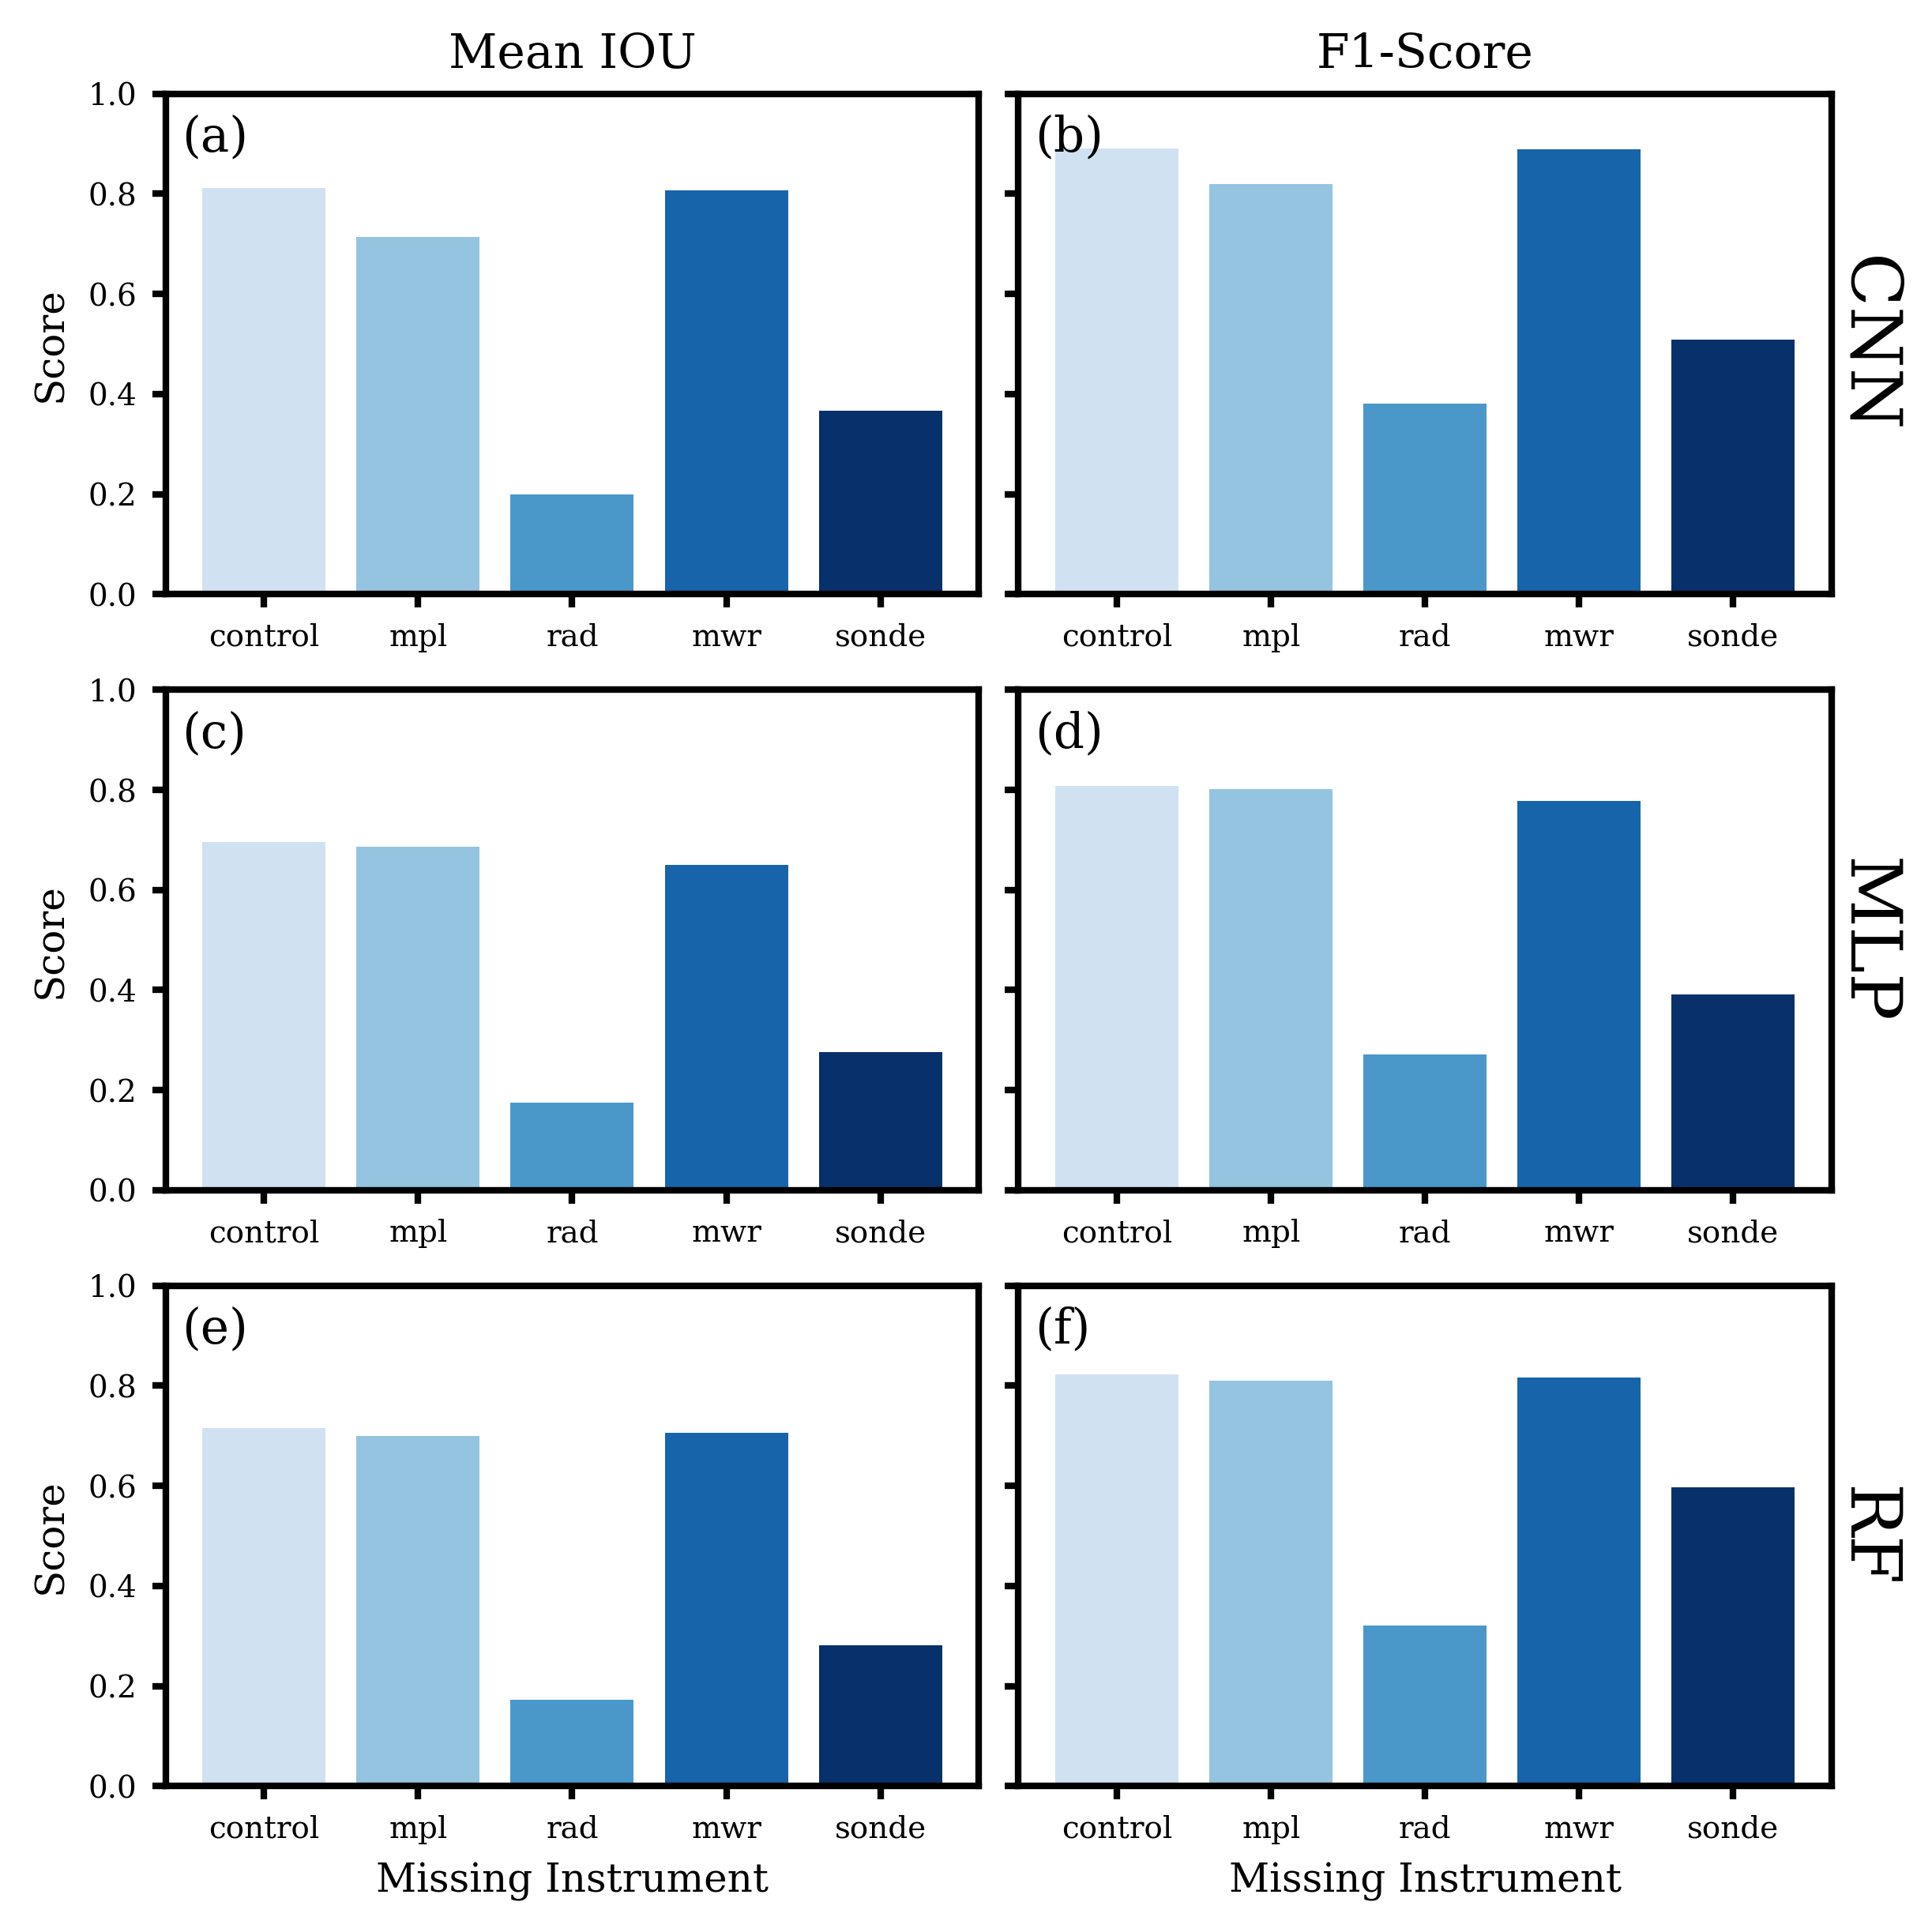

In [45]:
# Figure S1 in the supplemental

letters = ("(a)", "(b)", "(c)", "(d)", "(e)", "(f)")

models = {
    ("CNN", "cnn"): cnn_ablations,
    ("MLP", "mlp_balanced"): mlp_ablations,
    ("RF", "rf_balanced"): rf_ablations,
}
instrument_suffixes = ["", "_mpl", "_rad", "_mwr", "_sonde"]

fig, axs = plt.subplots(
    nrows=len(models),
    ncols=2,  # f1-score, mean iou score
    figsize=(6,6),
    constrained_layout=True,
    sharey=True,
)

for i, ((model_label, index_label), metrics_df) in enumerate(models.items()):
    indexes = [index_label + suffix for suffix in instrument_suffixes]
    index_labels = ["control"] + [label.split("_")[-1] for label in indexes[1:]]

    data = metrics_df.loc[indexes].reset_index(names="instrument")
    
    axs[i, 0].bar(
        index_labels,
        data["mean"],
        color=plt.cm.Blues([0.2 + 0.2*i for i in range(len(index_labels))])
    )
    axs[i, 0].set_xlabel("Missing Instrument" if (i == len(models) - 1) else "")
    axs[i, 0].set_ylabel("Score")
    axs[i, 0].set_ylim(0, 1)
    axs[i, 0].set_title("")
    

    axs[i, 1].bar(
        index_labels,
        data["f1"],
        color=plt.cm.Blues([0.2 + 0.2*i for i in range(len(index_labels))])
    )
    axs[i, 1].set_xlabel("Missing Instrument" if (i == len(models) - 1) else "")
    axs[i, 1].set_ylim(0, 1)
    axs[i, 1].set_title("")
    axs[i, 1].text(
        1,
        0.5,
        model_label,
        rotation=-90,
        ha='left',
        va='center',
        transform=axs[i, 1].transAxes,
        fontsize=16
    )

    axs[i, 0].text(
        x=0.02,
        y=0.96,
        s=letters[2*i],
        transform=axs[i, 0].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        # fontweight="bold",
        fontsize=11,
    )
    axs[i, 1].text(
        x=0.02,
        y=0.96,
        s=letters[2*i + 1],
        transform=axs[i, 1].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        # fontweight="bold",
        fontsize=11,
    )

axs[0, 0].set_title("Mean IOU")
axs[0, 1].set_title("F1-Score")

fig.savefig("figures/ablation.png")
plt.show()